In [2]:
import time
from datetime import timedelta
from crater_data import Data
from crater_loader import load_crater_data_wrapper, load_crater_data
from crater_nn import Network
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
images, labels, hot_one = load_crater_data()
data = Data(images, hot_one, random_state=42, build_images_col=True)
tr_d = list(zip(data.train.images_col, data.train.cls))
te_d = list(zip(data.test.images_col, data.test.cls))
va_d = list(zip(data.validation.images_col, data.validation.cls))

In [3]:
iteration = 0
experiment_data = []

In [4]:
input_size = 50*50

for i in range(1):
    iteration += 1

    start = time.time()
        
    # define the network shape to be used and the activation threshold
    model = Network([input_size, 8, 1], False)
    model.threshold = 0.3

    # the schedule is how the learning rate will be
    # changed during the training
    epochs = 100
    schedule = [(0.1)*(0.5)**np.floor(float(i)/(30)) for i in range(epochs)]
    #schedule = np.linspace(0.5, 0.01, epochs)
    for eta in schedule:
        # the total epochs is given by the schedule loop
        # we chose minibatch size to be 3
        model.SGD(tr_d, 1, 3, eta, te_d)

    end = time.time()

    # After training is complete, store this model training history
    # to the experiment data
    experiment_data.append(np.array(model.history))
    
    # store current results data to disk
    np.save("experiment_data", experiment_data)
    
    # save current model to disk
    with open('nn_model_%05d_%02d.pkl' % (input_size, i), 'wb') as output:
        pickle.dump(model, output)

    elapsed_time = end - start
    print (iteration, timedelta(seconds=elapsed_time))

1 0:00:05.890323


In [4]:
with open('nn_model_02500_00.pkl', 'rb') as finput:
    model = pickle.load(finput)

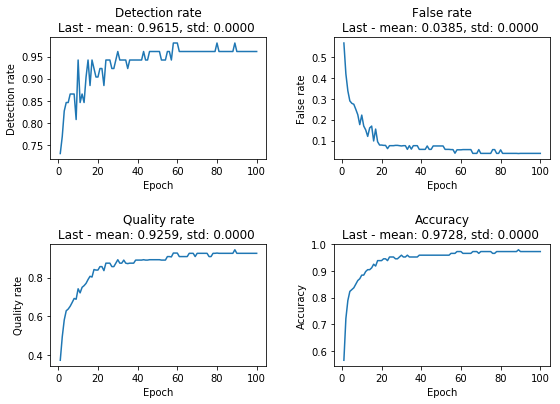

In [6]:
# data numpy array
# axis0: iterations, axis1: epochs, axis2: measurement
expdata = np.load("experiment_data.npy")

# extract temporal axis
epoch = expdata[ : , : , 0].mean(axis=0)

# list to store statistics for measurements
stats = []
# helper dictionary
stats_attr = {0: "TP", 1: "FP",  2: "FN",  3: "Detection rate",
              4: "False rate", 5: "Quality rate", 6: "Accuracy"}

for i in range(7):
    # a list for each measurement
    stats.append([])
    # compute statistics along iterations axis
    stats[i].append(expdata[ : , : , i+1].mean(axis=0))
    stats[i].append(expdata[ : , : , i+1].std(axis=0))
    stats[i].append(expdata[ : , : , i+1].min(axis=0))
    stats[i].append(expdata[ : , : , i+1].max(axis=0))

# finally plot statistics of evolution of our Network performance
plotstats = [3, 4, 5, 6]
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
fig.tight_layout(h_pad=8, w_pad=4)
fig.subplots_adjust(bottom=0.12, top=0.88, left=0.1)
for k, ax in enumerate(axarr.flatten()):
    i = plotstats[k]
    ax.set_xlabel("Epoch")
    ax.set_ylabel(stats_attr[i])
    ax.plot(epoch, stats[i][0])
    ax.set_title("%s\nLast - mean: %.4f, std: %.4f "
              % (stats_attr[i], stats[i][0][-1], stats[i][1][-1]))
    ax.fill_between(epoch, stats[i][0] - stats[i][1],
                    stats[i][0] + stats[i][1], alpha=0.4)
    ax.fill_between(epoch, stats[i][2], stats[i][3], alpha=0.4)

plt.show()

In [5]:
n = 100
print(model.feedforward(data.test.images_col[n]))
print(model.feedforward_flat(data.test.images[n])[0,0])

[[ 0.03787143]]
0.037871425062
